In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

In [3]:
# Label remapping

label_map = {
    'Not Drowsy': 'alert', 'Slight': 'drowsy', 'Moderate': 'moderate_very', 'Very': 'moderate_very'
}

# Feature list
features = [ 'EAR_mean', 'MAR_inner', 'MAR_outer','pose_Tx', 'pose_Ty', 'pose_Tz', 'pose_Rx', 'pose_Ry', 'pose_Rz',
]

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

# === Load original Catch22 full-frame train dataset ===
df = pd.read_csv('Classification_Combined_Data/S1_S2_train_data_c22.csv')

# === Drop metadata columns ===
feature_cols = [col for col in df.columns if col not in ['window_start', 'ID', 'Study', 'Label']]
X = df[feature_cols]
y = df['Label']

# === Encode labels ===
le = LabelEncoder()
y_enc = le.fit_transform(y)

# === Class distribution BEFORE SMOTE ===
print("📊 Class distribution before SMOTE:")
print(y.value_counts())

# === Apply SMOTE ===
smote = SMOTE(random_state=42)
X_sm, y_sm_enc = smote.fit_resample(X, y_enc)
y_sm = le.inverse_transform(y_sm_enc)

# === Create oversampled dataframe ===
X_sm_df = pd.DataFrame(X_sm, columns=feature_cols)
y_sm_df = pd.Series(y_sm, name='Label')
df_sm = pd.concat([y_sm_df, X_sm_df], axis=1)

# === Save oversampled version ===
df_sm.to_csv('Classification_Combined_Data/S1_S2_train_data_c22_SMOTE.csv', index=False)
print("\n✅ SMOTE-balanced data saved to: S1_S2_train_data_c22_SMOTE.csv")

# === Plot class distribution BEFORE/AFTER ===
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

y.value_counts().plot(kind='bar', ax=ax[0], title='Before SMOTE', color='skyblue')
pd.Series(y_sm).value_counts().plot(kind='bar', ax=ax[1], title='After SMOTE', color='seagreen')

for a in ax:
    a.set_xlabel("Label")
    a.set_ylabel("Count")
    a.tick_params(axis='x', rotation=15)

plt.suptitle("Class Distribution Before and After SMOTE")
plt.tight_layout()
plt.show()


🔍 Processing S1_P05 (59739 rows)
✅ 377 valid windows

🔍 Processing S1_P11 (48310 rows)
✅ 311 valid windows

🔍 Processing S1_P10 (49760 rows)
✅ 326 valid windows

🔍 Processing S1_P04 (18540 rows)
✅ 112 valid windows

🔍 Processing S1_P12 (42800 rows)
✅ 282 valid windows

🔍 Processing S1_P07 (56550 rows)
✅ 362 valid windows

🔍 Processing S1_P13 (19829 rows)
✅ 123 valid windows

🔍 Processing S1_P17 (27030 rows)
✅ 165 valid windows

🔍 Processing S1_P03 (59180 rows)
✅ 391 valid windows

🔍 Processing S1_P16 (19830 rows)
✅ 129 valid windows

🔍 Processing S2_P48 (27820 rows)
✅ 172 valid windows

🔍 Processing S1_P14 (31220 rows)
✅ 203 valid windows

🔍 Processing S1_P28 (21141 rows)
✅ 139 valid windows

🔍 Processing S1_P29 (27491 rows)
✅ 178 valid windows

🔍 Processing S1_P15 (35960 rows)
✅ 234 valid windows

🔍 Processing S2_P49 (18760 rows)
✅ 96 valid windows

🔍 Processing S2_P12 (18290 rows)
✅ 110 valid windows

🔍 Processing S2_P13 (36060 rows)
✅ 227 valid windows

🔍 Processing S2_P39 (19095 r

📊 Class distribution before SMOTE:
Label
drowsy    7316
alert     1633
Name: count, dtype: int64


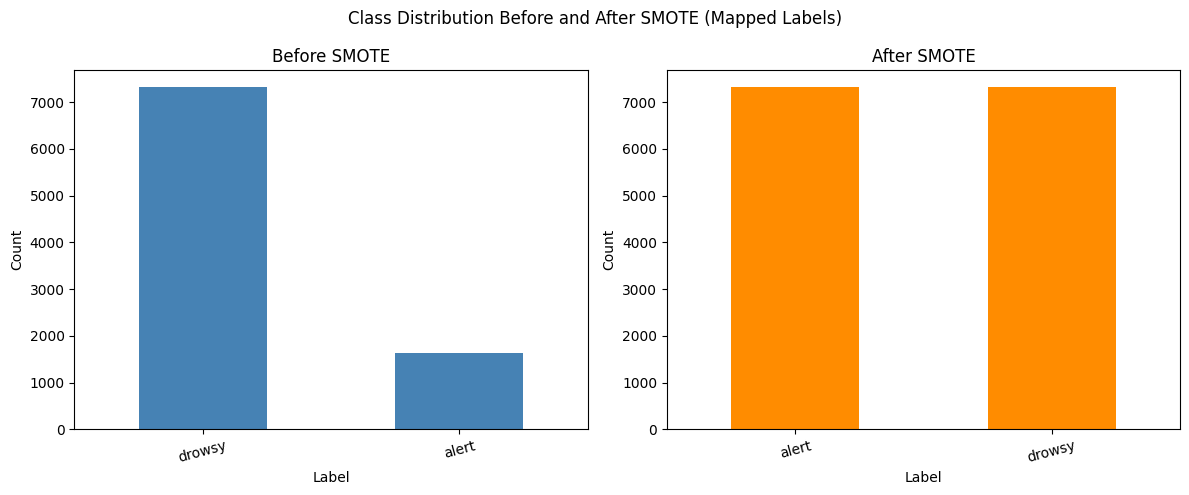

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

# === Load original dataset ===
df = pd.read_csv('Classification_Combined_Data/S1_S2_train_data_c22.csv')

# === Define label map ===
label_map = {
    'Not Drowsy': 'alert',
    'Slight': 'drowsy',
    'Moderate': 'drowsy',
    'Very': 'drowsy'
}
df['Label'] = df['Label'].map(label_map)

# === Drop metadata columns ===
feature_cols = [col for col in df.columns if col not in ['window_start', 'ID', 'Study', 'Label']]
X = df[feature_cols]
y = df['Label']

# === Encode remapped labels ===
le = LabelEncoder()
y_enc = le.fit_transform(y)

# === Class distribution BEFORE SMOTE ===
print("📊 Class distribution before SMOTE:")
print(y.value_counts())

# === Apply SMOTE ===
smote = SMOTE(random_state=42)
X_sm, y_sm_enc = smote.fit_resample(X, y_enc)
y_sm = le.inverse_transform(y_sm_enc)

# === Combine features + labels ===
X_sm_df = pd.DataFrame(X_sm, columns=feature_cols)
y_sm_df = pd.Series(y_sm, name='Label')
df_sm = pd.concat([y_sm_df, X_sm_df], axis=1)

# === Save oversampled dataset ===
# df_sm.to_csv('Classification_Combined_Data/S1_S2_train_data_c22_SMOTE_mapped.csv', index=False)
# print("\n✅ Mapped + SMOTEd data saved to: S1_S2_train_data_c22_SMOTE_mapped.csv")

# === Plot distributions ===
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
y.value_counts().plot(kind='bar', ax=ax[0], title='Before SMOTE', color='steelblue')
pd.Series(y_sm).value_counts().plot(kind='bar', ax=ax[1], title='After SMOTE', color='darkorange')

for a in ax:
    a.set_xlabel("Label")
    a.set_ylabel("Count")
    a.tick_params(axis='x', rotation=15)

plt.suptitle("Class Distribution Before and After SMOTE (Mapped Labels)")
plt.tight_layout()
plt.show()

🔍 Original train labels: ['Not Drowsy' 'Slight' 'Moderate' 'Very']
🔍 Original test labels: ['Not Drowsy' 'Slight' 'Moderate' 'Very']
✅ Train rows after mapping: 8949
✅ Test rows after mapping: 2035
✅ X_train shape: (8949, 220)
✅ X_test shape: (2035, 220)

📊 Dummy Classifier (Catch22 Features):
              precision    recall  f1-score   support

       alert       0.29      0.20      0.24       535
      drowsy       0.74      0.83      0.78      1500

    accuracy                           0.66      2035
   macro avg       0.52      0.51      0.51      2035
weighted avg       0.63      0.66      0.64      2035



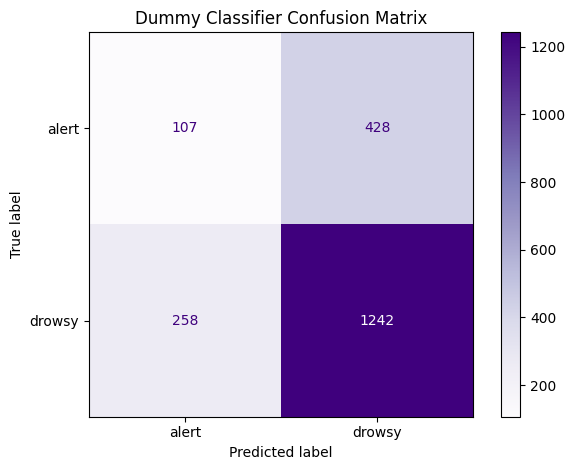

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# === FILE PATHS ===
train_path = 'Classification_Combined_Data/S1_S2_train_data_c22.csv'
test_path = 'Classification_Combined_Data/S1_S2_test_data_c22.csv'

# === LABEL MAP ===
label_map = {
    'Not Drowsy': 'alert',
    'Slight': 'drowsy',
    'Moderate': 'drowsy',
    'Very': 'drowsy'
}

# === LOAD DATA ===
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

print("🔍 Original train labels:", train_df['Label'].unique())
print("🔍 Original test labels:", test_df['Label'].unique())

# === APPLY MAPPING ONLY IF NEEDED ===
def map_labels(df):
    # Only map if raw labels are still in old form
    if any(lbl in df['Label'].unique() for lbl in label_map.keys()):
        df['Label'] = df['Label'].map(label_map)
    return df

train_df = map_labels(train_df)
test_df = map_labels(test_df)

train_df = train_df[train_df['Label'].notna()]
test_df = test_df[test_df['Label'].notna()]

print(f"✅ Train rows after mapping: {len(train_df)}")
print(f"✅ Test rows after mapping: {len(test_df)}")

# === FEATURE LIST (EXCLUDE METADATA) ===
meta_cols = ['window_start', 'ID', 'Study', 'Label']
features = [col for col in train_df.columns if col not in meta_cols]

# === SPLIT X/y ===
X_train = train_df[features]
y_train = train_df['Label']
X_test = test_df[features]
y_test = test_df['Label']

# === LABEL ENCODING ===
le = LabelEncoder()
le.fit(list(y_train) + list(y_test))
y_train_enc = le.transform(y_train)
y_test_enc = le.transform(y_test)

smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train_enc)

print("✅ X_train shape:", X_train.shape)
print("✅ X_test shape:", X_test.shape)

# === DUMMY CLASSIFIER ===
dummy_clf = DummyClassifier(strategy='stratified', random_state=42)
dummy_clf.fit(X_train, y_train_enc)
y_pred = dummy_clf.predict(X_test)

# === LABEL ORDERING ===
custom_order = ['alert', 'drowsy']
custom_label_indices = [le.classes_.tolist().index(lbl) for lbl in custom_order if lbl in le.classes_]

# === REPORT ===
print("\n📊 Dummy Classifier (Catch22 Features):")
print(classification_report(
    y_test_enc,
    y_pred,
    labels=custom_label_indices,
    target_names=[le.classes_[i] for i in custom_label_indices]
))

# === CONFUSION MATRIX ===
ConfusionMatrixDisplay.from_predictions(
    y_test_enc,
    y_pred,
    labels=custom_label_indices,
    display_labels=[le.classes_[i] for i in custom_label_indices],
    cmap='Purples'
)
plt.title("Dummy Classifier Confusion Matrix")
plt.tight_layout()
plt.show()

🔍 Original train labels: ['Not Drowsy' 'Slight' 'Moderate' 'Very']
🔍 Original test labels: ['Not Drowsy' 'Slight' 'Moderate' 'Very']
✅ Train rows after mapping: 8949
✅ Test rows after mapping: 2035

📊 Random Forest (Catch22 Features):
              precision    recall  f1-score   support

       alert       0.51      0.10      0.17       535
      drowsy       0.75      0.97      0.84      1500

    accuracy                           0.74      2035
   macro avg       0.63      0.53      0.51      2035
weighted avg       0.69      0.74      0.67      2035

Balanced F1 Score (macro): 0.5053
Balanced F1 Score (weighted): 0.6662
ROC AUC: 0.6371


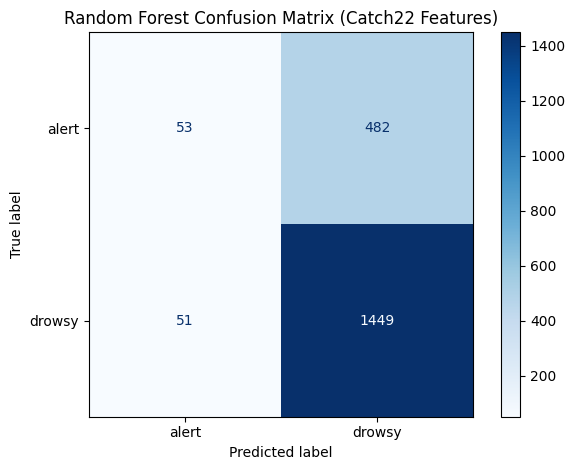

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report,
    ConfusionMatrixDisplay,
    f1_score,
    roc_auc_score
)
from imblearn.over_sampling import SMOTE

# === FILE PATHS ===
train_path = 'Classification_Combined_Data/S1_S2_train_data_c22.csv'
test_path = 'Classification_Combined_Data/S1_S2_test_data_c22.csv'

# === LABEL MAP ===
label_map = {
    'Not Drowsy': 'alert',
    'Slight': 'drowsy',
    'Moderate': 'drowsy',
    'Very': 'drowsy'
}

# === LOAD DATA ===
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

print("🔍 Original train labels:", train_df['Label'].unique())
print("🔍 Original test labels:", test_df['Label'].unique())

# === APPLY MAPPING ONLY IF NEEDED ===
def map_labels(df):
    if any(lbl in df['Label'].unique() for lbl in label_map.keys()):
        df['Label'] = df['Label'].map(label_map)
    return df

train_df = map_labels(train_df)
test_df = map_labels(test_df)

train_df = train_df[train_df['Label'].notna()]
test_df = test_df[test_df['Label'].notna()]

print(f"✅ Train rows after mapping: {len(train_df)}")
print(f"✅ Test rows after mapping: {len(test_df)}")

# === FEATURE SELECTION ===
non_features = ['window_start', 'ID', 'Study', 'Label']
features = [col for col in train_df.columns if col not in non_features]

X_train = train_df[features]
y_train = train_df['Label']
X_test = test_df[features]
y_test = test_df['Label']

# === ENCODE LABELS (TRAIN+TEST UNION) ===
le = LabelEncoder()
le.fit(list(y_train) + list(y_test))
y_train_enc = le.transform(y_train)
y_test_enc = le.transform(y_test)

# === SMOTE BALANCING (OPTIONAL — ALREADY SMOTE IN TRAIN FILE, SKIP IF YOU WANT) ===
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train_enc)
# print("✅ After SMOTE:", np.bincount(y_train_sm))

# # Use directly (since SMOTE already applied during feature creation)
# X_train_sm, y_train_sm = X_train, y_train_enc

# === TRAIN RANDOM FOREST ===
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=4,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_sm, y_train_sm)

# === PREDICT ===
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)

# === CUSTOM LABEL ORDER ===
custom_order = ['alert', 'drowsy']
custom_label_indices = [le.classes_.tolist().index(lbl) for lbl in custom_order if lbl in le.classes_]

# === CLASSIFICATION REPORT ===
print("\n📊 Random Forest (Catch22 Features):")
print(classification_report(
    y_test_enc,
    y_pred_rf,
    labels=custom_label_indices,
    target_names=[le.classes_[i] for i in custom_label_indices]
))

# === F1 SCORES ===
f1_macro = f1_score(y_test_enc, y_pred_rf, average='macro')
f1_weighted = f1_score(y_test_enc, y_pred_rf, average='weighted')
print(f"Balanced F1 Score (macro): {f1_macro:.4f}")
print(f"Balanced F1 Score (weighted): {f1_weighted:.4f}")

# === ROC-AUC (Handles multi-class automatically) ===
if len(le.classes_) == 2:
    auc_score = roc_auc_score(y_test_enc, y_proba_rf[:, 1])
else:
    auc_score = roc_auc_score(y_test_enc, y_proba_rf, multi_class='ovr', average='macro')

print(f"ROC AUC: {auc_score:.4f}")

# === CONFUSION MATRIX ===
ConfusionMatrixDisplay.from_predictions(
    y_test_enc,
    y_pred_rf,
    labels=custom_label_indices,
    display_labels=[le.classes_[i] for i in custom_label_indices],
    cmap='Blues'
)
plt.title("Random Forest Confusion Matrix (Catch22 Features)")
plt.tight_layout()
plt.show()

/Users/aaryannagpal1/Documents/Thesis/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:46:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📊 XGBoost Classifier Report:
              precision    recall  f1-score   support

       alert       0.39      0.14      0.21       535
      drowsy       0.75      0.92      0.83      1500

    accuracy                           0.71      2035
   macro avg       0.57      0.53      0.52      2035
weighted avg       0.65      0.71      0.66      2035

Balanced F1 Score (macro): 0.5180
Balanced F1 Score (weighted): 0.6641
ROC AUC: 0.5965


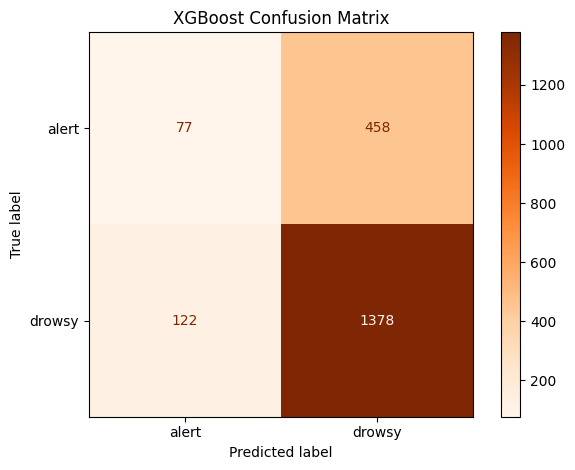

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report,
    f1_score,
    roc_auc_score,
    ConfusionMatrixDisplay
)
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# === LABEL MAP ===
label_map = {
    'Not Drowsy': 'alert',
    'Slight': 'drowsy',
    'Moderate': 'drowsy',
    'Very': 'drowsy'
}

# === FILE PATHS ===
train_path = 'Classification_Combined_Data/S1_S2_train_data_c22.csv'
test_path = 'Classification_Combined_Data/S1_S2_test_data_c22.csv'

# === LOAD DATA ===
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# === MAP LABELS ===
train_df['Label'] = train_df['Label'].map(label_map)
test_df['Label'] = test_df['Label'].map(label_map)
train_df = train_df[train_df['Label'].notna()]
test_df = test_df[test_df['Label'].notna()]

# === FEATURES ===
meta_cols = ['window_start', 'ID', 'Study', 'Label']
features = [col for col in train_df.columns if col not in meta_cols]

# === SPLIT X/y ===
X_train = train_df[features]
y_train = train_df['Label']
X_test = test_df[features]
y_test = test_df['Label']

# === LABEL ENCODING ===
le = LabelEncoder()
le.fit(list(y_train) + list(y_test))
y_train_enc = le.transform(y_train)
y_test_enc = le.transform(y_test)

# === SMOTE BALANCING ===
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train_enc)

# === XGBOOST CLASSIFIER ===
xgb = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)
xgb.fit(X_train_sm, y_train_sm)

# === PREDICTIONS ===
y_pred = xgb.predict(X_test)
y_proba = xgb.predict_proba(X_test)

# === METRICS ===
custom_order = ['alert', 'drowsy']
custom_label_indices = [list(le.classes_).index(lbl) for lbl in custom_order]

print("\n📊 XGBoost Classifier Report:")
print(classification_report(
    y_test_enc,
    y_pred,
    labels=custom_label_indices,
    target_names=custom_order
))

f1_macro = f1_score(y_test_enc, y_pred, average='macro')
f1_weighted = f1_score(y_test_enc, y_pred, average='weighted')
print(f"Balanced F1 Score (macro): {f1_macro:.4f}")
print(f"Balanced F1 Score (weighted): {f1_weighted:.4f}")

if len(np.unique(y_test_enc)) == 2:
    auc_score = roc_auc_score(y_test_enc, y_proba[:, 1])
else:
    auc_score = roc_auc_score(y_test_enc, y_proba, multi_class='ovr', average='macro')
print(f"ROC AUC: {auc_score:.4f}")

# === CONFUSION MATRIX ===
ConfusionMatrixDisplay.from_predictions(
    y_test_enc,
    y_pred,
    labels=custom_label_indices,
    display_labels=custom_order,
    cmap='Oranges'
)
plt.title("XGBoost Confusion Matrix")
plt.tight_layout()
plt.show()

Iteration 1, loss = 2.02094927
Validation score: 0.589240
Iteration 2, loss = 0.78145964
Validation score: 0.617421
Iteration 3, loss = 0.70526139
Validation score: 0.635354
Iteration 4, loss = 0.65157066
Validation score: 0.663535
Iteration 5, loss = 0.60799190
Validation score: 0.672929
Iteration 6, loss = 0.58483722
Validation score: 0.669513
Iteration 7, loss = 0.57108920
Validation score: 0.686593
Iteration 8, loss = 0.54009612
Validation score: 0.696840
Iteration 9, loss = 0.52386305
Validation score: 0.704526
Iteration 10, loss = 0.51251789
Validation score: 0.713066
Iteration 11, loss = 0.50161264
Validation score: 0.713920
Iteration 12, loss = 0.48368654
Validation score: 0.709650
Iteration 13, loss = 0.47716288
Validation score: 0.723313
Iteration 14, loss = 0.46320922
Validation score: 0.728437
Iteration 15, loss = 0.44961527
Validation score: 0.720751
Iteration 16, loss = 0.44174059
Validation score: 0.748079
Iteration 17, loss = 0.42922733
Validation score: 0.738685
Iterat

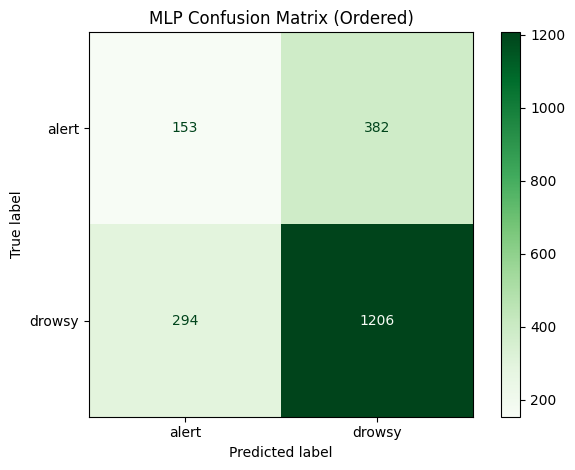

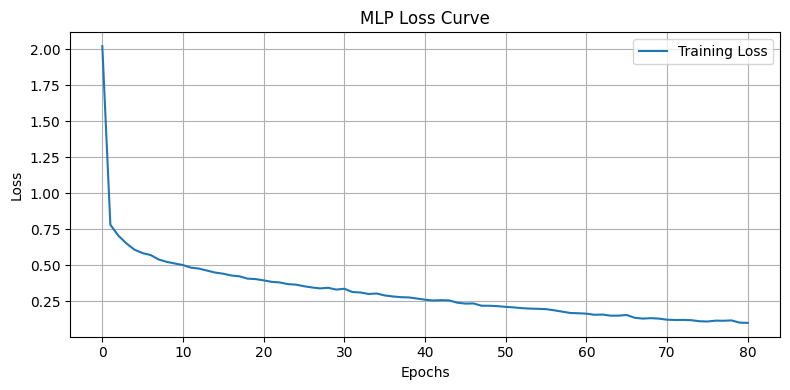

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    ConfusionMatrixDisplay,
    f1_score,
    roc_auc_score
)
from imblearn.over_sampling import SMOTE

# === LABEL MAP ===
label_map = {
    'Not Drowsy': 'alert',
    'Slight': 'drowsy',
    'Moderate': 'drowsy',
    'Very': 'drowsy'
}

# === LOAD C22 DATA ===
train_df = pd.read_csv('Classification_Combined_Data/S1_S2_train_data_c22.csv')
test_df = pd.read_csv('Classification_Combined_Data/S1_S2_test_data_c22.csv')

train_df['Label'] = train_df['Label'].map(label_map)
test_df['Label'] = test_df['Label'].map(label_map)

train_df = train_df[train_df['Label'].notna()]
test_df = test_df[test_df['Label'].notna()]

# === EXTRACT FEATURES & LABELS ===
non_features = ['ID', 'Study', 'window_start', 'Label']
features = [col for col in train_df.columns if col not in non_features]

X_train = train_df[features]
y_train = train_df['Label']
X_test = test_df[features]
y_test = test_df['Label']

# === LABEL ENCODING ===
le = LabelEncoder()
le.fit(list(y_train) + list(y_test))
y_train_enc = le.transform(y_train)
y_test_enc = le.transform(y_test)

# === SMOTE BALANCING ===
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train_enc)

# === VALIDATION SPLIT ===
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_sm, y_train_sm, test_size=0.2, random_state=42, stratify=y_train_sm
)

# === DEFINE MLP MODEL ===
mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    max_iter=100,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    verbose=True,
    n_iter_no_change=10
)

# === FIT ===
mlp.fit(X_tr, y_tr)

# === PREDICT ON TEST ===
y_pred_mlp = mlp.predict(X_test)
y_proba_mlp = mlp.predict_proba(X_test)

# === CUSTOM LABEL ORDER ===
custom_order = ['alert', 'drowsy']
custom_label_indices = [list(le.classes_).index(lbl) for lbl in custom_order]

# === METRICS ===
print("MLP:\n")
print(classification_report(
    y_test_enc,
    y_pred_mlp,
    labels=custom_label_indices,
    target_names=custom_order
))

f1_macro = f1_score(y_test_enc, y_pred_mlp, average='macro')
f1_weighted = f1_score(y_test_enc, y_pred_mlp, average='weighted')
print(f"Balanced F1 Score (macro): {f1_macro:.4f}")
print(f"Balanced F1 Score (weighted): {f1_weighted:.4f}")

if len(np.unique(y_test_enc)) == 2:
    auc_score = roc_auc_score(y_test_enc, y_proba_mlp[:, 1])
else:
    auc_score = roc_auc_score(y_test_enc, y_proba_mlp, multi_class='ovr', average='macro')
print(f"ROC AUC: {auc_score:.4f}")

# === CONFUSION MATRIX ===
ConfusionMatrixDisplay.from_predictions(
    y_test_enc,
    y_pred_mlp,
    labels=custom_label_indices,
    display_labels=custom_order,
    cmap='Greens'
)
plt.title("MLP Confusion Matrix (Ordered)")
plt.tight_layout()
plt.show()

# === LOSS CURVE ===
plt.figure(figsize=(8, 4))
plt.plot(mlp.loss_curve_, label='Training Loss')
plt.title("MLP Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
#Catch22 on all 20 features first
#Then from the 440 features run feature importance, select top xx and run the models again
#Elbow diagram to select number of features